In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
image_folder = '/content/drive/MyDrive/Medical_image_Reporting/Images'
df_path = '/content/drive/MyDrive/Medical_image_Reporting/df_final.pkl'
chexnet_weights = '/content/drive/MyDrive/Medical_image_Reporting/ChexNet weights/brucechou1983_CheXNet_Keras_0.3.0_weights.h5'

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib #for saving model files as pkl files
import os
import seaborn as sns
import cv2
import imgaug.augmenters as iaa
sns.set(palette='muted',style='white')
import tensorflow as tf
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D, Input, Embedding, LSTM,Dot,Reshape,Concatenate,BatchNormalization, GlobalMaxPooling2D, Dropout, Add
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import sentence_bleu #bleu score
tf.compat.v1.enable_eager_execution()
import os
import math
# os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="false" #https://github.com/tensorflow/tensorflow/issues/33721#issuecomment-577307175

# **Creating Tokenizer**

In [ ]:
df = pd.read_pickle(df_path)
col = ['image_1','image_2','impression','xml file name']
df = df[col].copy()
#path
df['image_1'] = df['image_1'].apply(lambda row: os.path.join(image_folder,row)) #https://stackoverflow.com/a/61880790
df['image_2'] = df['image_2'].apply(lambda row: os.path.join(image_folder,row))

df['impression_final'] = '<CLS> ' + df.impression + ' <END>'
df['impression_ip'] = '<CLS> ' + df.impression
df['impression_op'] = df.impression + ' <END>' 
print(df.shape)
df.head(2)

(4033, 7)


,image_1,image_2,impression,xml file name,impression_final,impression_ip,impression_op
0,/content/drive/My Drive/Medical image Reportin...,/content/drive/My Drive/Medical image Reportin...,bilateral lower lobe opacities . the appearanc...,597.xml,<CLS> bilateral lower lobe opacities . the app...,<CLS> bilateral lower lobe opacities . the app...,bilateral lower lobe opacities . the appearanc...
1,/content/drive/My Drive/Medical image Reportin...,/content/drive/My Drive/Medical image Reportin...,bilateral lower lung airspace disease right gr...,601.xml,<CLS> bilateral lower lung airspace disease ri...,<CLS> bilateral lower lung airspace disease ri...,bilateral lower lung airspace disease right gr...


In [ ]:
df['impression'].value_counts()

no acute cardiopulmonary abnormality .                                                                                                                                                                                                                                                                                                                                                                                                                                      383
no acute cardiopulmonary findings .                                                                                                                                                                                                                                                                                                                                                                                                                                         172
no acute cardiopulmonary disease .                                      

Here we can see that some captions have only 1 values in the entire dataset while some datasets are having more than 5. What I will do here is that I will upsample all those datapoint which impression value counts <=5. First I will remove all those datapoints which are duplicated based on xml file name(ie of the same patient because some patients are having more than 2 images) and then split the data into train and test.

In [ ]:
df.drop_duplicates(subset = ['xml file name'], inplace = True)

In [ ]:
#adding a new column impression counts which tells the total value counts of impression of that datapoint 
k = df['impression'].value_counts()
df = df.merge(k,
         left_on = 'impression',
         right_index=True) #join left impression value with right index

df.columns

Index(['impression', 'image_1', 'image_2', 'impression_x', 'xml file name',
       'impression_final', 'impression_ip', 'impression_op', 'impression_y'],
      dtype='object')

In [ ]:
df.columns = ['impression', 'image_1', 'image_2', 'impression_x', 'xml file name','impression_final',
       'impression_ip', 'impression_op', 'impression_counts'] #changin column names
del df['impression_x'] #deleting impression_x column
df.head()

,impression,image_1,image_2,xml file name,impression_final,impression_ip,impression_op,impression_counts
0,bilateral lower lobe opacities . the appearanc...,/content/drive/My Drive/Medical image Reportin...,/content/drive/My Drive/Medical image Reportin...,597.xml,<CLS> bilateral lower lobe opacities . the app...,<CLS> bilateral lower lobe opacities . the app...,bilateral lower lobe opacities . the appearanc...,1
1,bilateral lower lung airspace disease right gr...,/content/drive/My Drive/Medical image Reportin...,/content/drive/My Drive/Medical image Reportin...,601.xml,<CLS> bilateral lower lung airspace disease ri...,<CLS> bilateral lower lung airspace disease ri...,bilateral lower lung airspace disease right gr...,1
2,negative for acute abnormality .,/content/drive/My Drive/Medical image Reportin...,/content/drive/My Drive/Medical image Reportin...,600.xml,<CLS> negative for acute abnormality . <END>,<CLS> negative for acute abnormality .,negative for acute abnormality . <END>,30
142,negative for acute abnormality .,/content/drive/My Drive/Medical image Reportin...,/content/drive/My Drive/Medical image Reportin...,704.xml,<CLS> negative for acute abnormality . <END>,<CLS> negative for acute abnormality .,negative for acute abnormality . <END>,30
149,negative for acute abnormality .,/content/drive/My Drive/Medical image Reportin...,/content/drive/My Drive/Medical image Reportin...,698.xml,<CLS> negative for acute abnormality . <END>,<CLS> negative for acute abnormality .,negative for acute abnormality . <END>,30


In [ ]:
from sklearn.model_selection import train_test_split
other1 = df[df['impression_counts']>5] #selecting those datapoints which have impression valuecounts >5
other2 = df[df['impression_counts']<=5] #selecting those datapoints which have impression valuecounts <=5
train,test = train_test_split(other1,stratify = other1['impression'].values,test_size = 0.1,random_state = 420)
test_other2_sample = other2.sample(int(0.2*other2.shape[0]),random_state = 420) #getting some datapoints from other2 data for test data
other2 = other2.drop(test_other2_sample.index,axis=0)
#here i will be choosing 0.5 as the test size as to create a reasonable size of test data
test = test.append(test_other2_sample)
test = test.reset_index(drop=True)

train = train.append(other2) 
train = train.reset_index(drop=True)
train.shape[0],test.shape[0]

(3257, 563)

Now we will upsample and downsample certain datapooints.

In [ ]:
from sklearn.utils import resample
df_majority = train[train['impression_counts']>=100] #having value counts >=100
df_minority = train[train['impression_counts']<=5] #having value counts <=5
df_other = train[(train['impression_counts']>5)&(train['impression_counts']<100)] #value counts between 5 and 100
n1 = df_minority.shape[0]
n2 = df_majority.shape[0]
n3 = df_other.shape[0]
#we will upsample them to 30
df_minority_upsampled = resample(df_minority,
                                 replace = True,
                                 n_samples = 3*n1,
                                 random_state = 420)
df_majority_downsampled = resample(df_majority,
                                 replace = False,
                                 n_samples = n2//15,
                                 random_state = 420)
df_other_downsampled = resample(df_other,
                                 replace = False,
                                 n_samples = n3//10,
                                 random_state = 420)

train = pd.concat([df_majority_downsampled ,df_minority_upsampled,df_other_downsampled])
train = train.reset_index(drop=True)
# del df_minority_upsampled,df_minority,df_majority,df_other,df_other_downsampled
train.shape

(4487, 8)

In [ ]:
train.impression.value_counts()

normal chest film .                                                                                                                                                                                                                                                                                                                                                                            18
no acute cardiopulmonary abnormality .                                                                                                                                                                                                                                                                                                                                                         17
cardiomegaly no acute pulmonary findings                                                                                                                                                                                            

In [ ]:
# folder_name = '/content/drive/MyDrive/Medical image Reporting/pickle_files'
# file_name = 'train.pkl'
# train.to_pickle(os.path.join(folder_name,file_name))

# file_name = 'test.pkl'
# test.to_pickle(os.path.join(folder_name,file_name))

In [ ]:
folder_name = '/content/drive/MyDrive/Medical_image_Reporting/pickle_files'
file_name = 'train.pkl'
train = pd.read_pickle(os.path.join(folder_name,file_name))

file_name = 'test.pkl'
test = pd.read_pickle(os.path.join(folder_name,file_name))

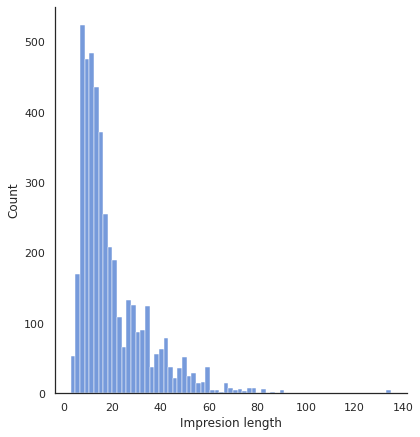


Value Counts for caption length top 5 values

Length|Counts
7     276
12    269
8     248
9     239
10    237
dtype: int64

The max and min value of "caption length" was found to be 135 and 3 respectively
The 80 percentile value of caption_len which is 29 will be taken as the maximum padded value for each impression


In [ ]:
#tokenizer
tokenizer = Tokenizer(filters = '',oov_token = '<unk>') #setting filters to none
tokenizer.fit_on_texts(train.impression_final.values)
train_captions = tokenizer.texts_to_sequences(train.impression_final) 
test_captions = tokenizer.texts_to_sequences(test.impression_final) 
vocab_size = len(tokenizer.word_index)
caption_len = np.array([len(i) for i in train_captions])
start_index = tokenizer.word_index['<cls>'] #tokened value of <cls>
end_index = tokenizer.word_index['<end>'] #tokened value of <end>


#visualising impression length and other details
ax = sns.displot(caption_len,height = 6)
ax.set_titles('Value Counts vs Caption Length')
ax.set_xlabels('Impresion length')
plt.show()
print('\nValue Counts for caption length top 5 values\n')
print('Length|Counts')
print(pd.Series(caption_len).value_counts()[:5])
print('\nThe max and min value of "caption length" was found to be %i and %i respectively'%(max(caption_len),min(caption_len)))
print('The 80 percentile value of caption_len which is %i will be taken as the maximum padded value for each impression'%(np.percentile(caption_len,80)))
max_pad = int(np.percentile(caption_len,80))
del train_captions,test_captions #we will create tokenizing  and padding in-built in dataloader